###**Document retrieval from wikipedia**
Document retrieval is defined as the matching of some stated user query against a set of free-text records. These records could be any type of mainly unstructured text, such as newspaper articles, real estate records or paragraphs in a manual. User queries can range from multi-sentence full descriptions of an information need to a few words.

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import paired_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

%matplotlib inline


In [0]:
df = pd.read_csv("people_wiki.csv", delimiter=",")

In [0]:
df.head(5)

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [0]:
Digby=df[df['name'] == 'Digby Morrell']
Digby

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...


In [0]:
Digby['text']

0    digby morrell born 10 october 1979 is a former...
Name: text, dtype: object

In [0]:

# Bag of Words model
Bag = CountVectorizer().fit_transform(df['text'])
#NearestNeighbors model
model = NearestNeighbors(metric = 'euclidean').fit(Bag)
 

In [0]:
#  Digby Morrell's top 5 nearest neighbors
Digby_Morrell_index = df[df['name'] == 'Digby Morrell'].index[0]
distances, indices = model.kneighbors(Bag[Digby_Morrell_index], n_neighbors = 5)


In [0]:
distances

array([[ 0.        , 18.27566688, 19.10497317, 19.18332609, 19.49358869]])

In [0]:
distance = pd.DataFrame({'Distance': distances.flatten(), 'ID': indices.flatten() })
near = (df.merge(distance, right_on = 'ID', left_index = True).sort_values('Distance')[['ID', 'name', 'Distance']])
near

,ID,name,Distance
0,0,Digby Morrell,0.000000
1,32472,Steven Browne,18.275667
2,8758,Dylan McLaren,19.104973
3,36597,Peter Freeman (footballer),19.183326
4,32924,Bret Hutchinson,19.493589


Compute TF-IDF for the corpus


In [0]:
def word(vect, word_weight):
    
    feature_names = np.array(vect.get_feature_names())
    data = word_weight.data
    indptr = word_weight.indptr
    indices = word_weight.indices
    n_docs = word_weight.shape[0]
    
    word_weight_list = []
    for i in range(n_docs):
        doc = slice(indptr[i], indptr[i + 1])
        count, idx = data[doc], indices[doc]
        feature = feature_names[idx]
        word_weight_dict = Counter({k: v for k, v in zip(feature, count)})
        word_weight_list.append(word_weight_dict)
    
    return word_weight_list

In [0]:
diag = CountVectorizer()
num_word = diag.fit_transform(df['text'])

In [0]:
df['word_weight'] = word(diag, num_word)
df.head(3)

,URI,name,text,word_weight
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'digby': 1, 'morrell': 5, 'born': 1, '10': 1,..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'is': 2, 'with': 2, 'the': 2, 'and': 10, 'in'..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'is': 7, 'who': 1, 'with': 4, 'the': 12, 'and..."


###TF-IDF

In [0]:
# tf-idf instead of bag of words
newtf = TfidfVectorizer()
ntd = newtf.fit_transform(df['text'])

 
 
co = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
co.fit(ntd)
Digby_M= df[df['name'] == 'Digby Morrell'].index[0]
cosine, indices = co.kneighbors(ntd[Digby_M], n_neighbors = 100)


nei= pd.DataFrame({'cosine': cosine.flatten(), 'id': indices.flatten()})
neare = (df.
                merge(nei, right_on = 'id', left_index = True).
                sort_values('cosine')[['id', 'name', 'cosine']])

neare.head()

,id,name,cosine
0,0,Digby Morrell,0.000000
1,32472,Steven Browne,0.516072
2,36597,Peter Freeman (footballer),0.575215
3,1347,Lindsay Smith (Australian footballer),0.591327
4,40090,Mitch Robinson,0.596708


In [0]:

def long (ligne):
    return len(ligne.split(' '))


df['length'] = df['text'].apply(long) 
neare = (df.
                  merge(nei, right_on = 'id', left_index = True).
                  sort_values('cosine')[['id', 'name', 'cosine', 'length']])
neare.head()

,id,name,cosine,length
0,0,Digby Morrell,0.000000,251
1,32472,Steven Browne,0.516072,213
2,36597,Peter Freeman (footballer),0.575215,222
3,1347,Lindsay Smith (Australian footballer),0.591327,215
4,40090,Mitch Robinson,0.596708,333


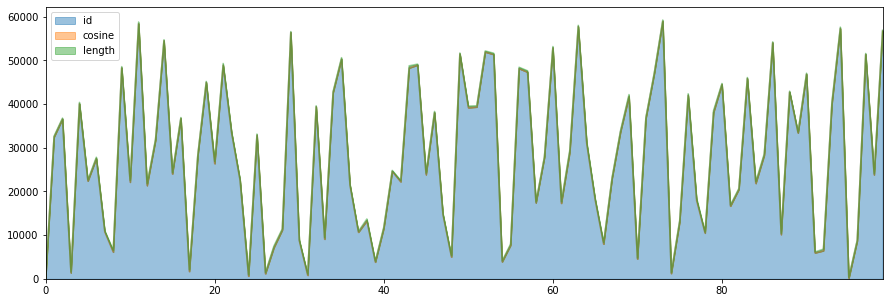

In [0]:

neare.plot(kind='area',alpha=0.45,figsize=(15, 5))

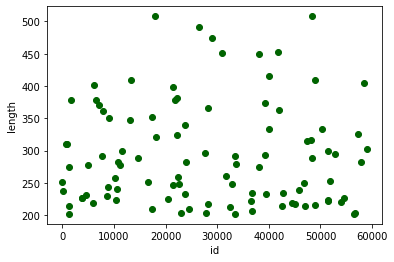

In [0]:

plt.scatter(neare["id"], neare["length"],  color='darkgreen')
plt.xlabel("id")
plt.ylabel("length")
plt.show()